# 🏗️Import Necessary Libraries

In [ ]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import itertools
import random
from scipy import stats
import imutils
import glob
import os

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
from PIL import Image as PILImage
from IPython.display import display, Image as DisplayImage

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix

#Inisialisasi dan import Library
import pandas as pd
import numpy as np
import seaborn as sns
import re
import string


!gdown 1Cxjeyi-RibTtY6RPV9fg_nHBXvydl4lf

Downloading...
From (original): https://drive.google.com/uc?id=1Cxjeyi-RibTtY6RPV9fg_nHBXvydl4lf
From (redirected): https://drive.google.com/uc?id=1Cxjeyi-RibTtY6RPV9fg_nHBXvydl4lf&confirm=t&uuid=908c9448-e674-4cf5-afb8-d603f1e6f020
To: /content/DATASET IRIS MATA.zip
100% 39.1M/39.1M [00:01<00:00, 28.9MB/s]


# 🤙Create helper functions

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

--2024-07-02 21:28:41--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-07-02 21:28:41 (67.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



# 📥Load and Transform Data

In [ ]:
import zipfile

# Tentukan path ke file zip
zip_file_path = '/content/DATASET IRIS MATA.zip'

# Tentukan path untuk mengekstrak file zip
extracted_folder_path = '/content'

# Mengekstrak file zip
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

# List semua file yang telah diekstrak
extracted_files = os.listdir(extracted_folder_path)
print("File telah diekstrak:", extracted_files)

File telah diekstrak: ['.config', 'DATASET IRIS MATA', 'DATASET IRIS MATA.zip', '__pycache__', 'helper_functions.py', 'sample_data']


In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = (300, 300)

In [ ]:
# Walk through each directory
dataset = "/content/DATASET IRIS MATA"
walk_through_dir(dataset)

There are 2 directories and 0 images in '/content/DATASET IRIS MATA'.
There are 0 directories and 100 images in '/content/DATASET IRIS MATA/KOLESTEROL'.
There are 0 directories and 100 images in '/content/DATASET IRIS MATA/NORMAL'.


# 📅Placing data into a Dataframe
The first column `filepaths` contains the file path location of each individual images. The second column `labels`, on the other hand, contains the class label of the corresponding image from the file path

In [ ]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png'))  + list(image_dir.glob(r'**/*.jpeg')) + list(image_dir.glob(r'**/*.gif'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

In [ ]:
image_df

Filepath       Label
0    /content/DATASET IRIS MATA/KOLESTEROL/kolester...  KOLESTEROL
1    /content/DATASET IRIS MATA/KOLESTEROL/kolester...  KOLESTEROL
2    /content/DATASET IRIS MATA/KOLESTEROL/kolester...  KOLESTEROL
3    /content/DATASET IRIS MATA/KOLESTEROL/kolester...  KOLESTEROL
4    /content/DATASET IRIS MATA/KOLESTEROL/kolester...  KOLESTEROL
..                                                 ...         ...
195    /content/DATASET IRIS MATA/NORMAL/normal-42.jpg      NORMAL
196    /content/DATASET IRIS MATA/NORMAL/normal-86.jpg      NORMAL
197    /content/DATASET IRIS MATA/NORMAL/normal-36.jpg      NORMAL
198    /content/DATASET IRIS MATA/NORMAL/normal-73.jpg      NORMAL
199     /content/DATASET IRIS MATA/NORMAL/normal-4.jpg      NORMAL

[200 rows x 2 columns]

# 🔭Visualizing images from the dataset

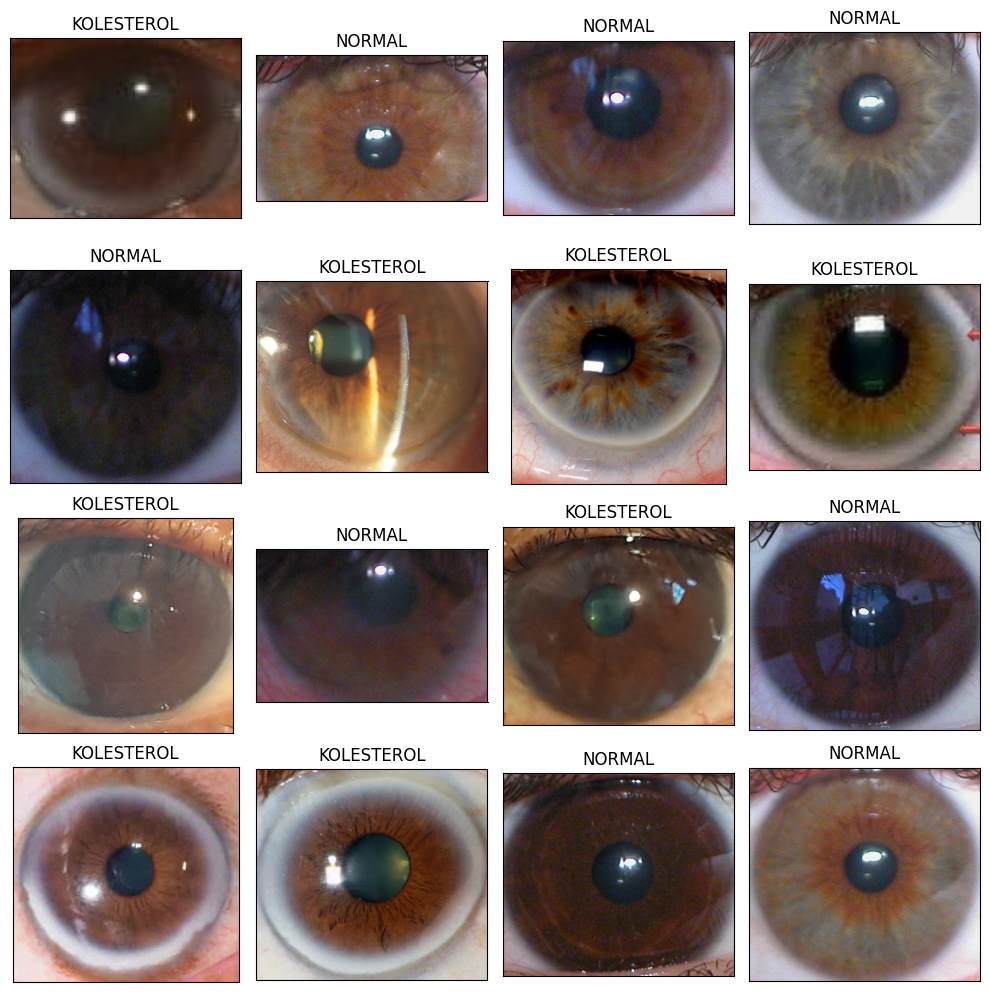

In [ ]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

# 🧮Computing Error Rate Analysis

In [ ]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)

    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])

    # read compressed image
    compressed_img = cv2.imread(temp_filename)

    # get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    return diff


def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)

    ela_image = ImageChops.difference(image, temp_image)

    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1

    scale = 255.0 / max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    return ela_image


def random_sample(path, extension=None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')

    items = list(items)

    p = random.choice(items)
    return p.as_posix()

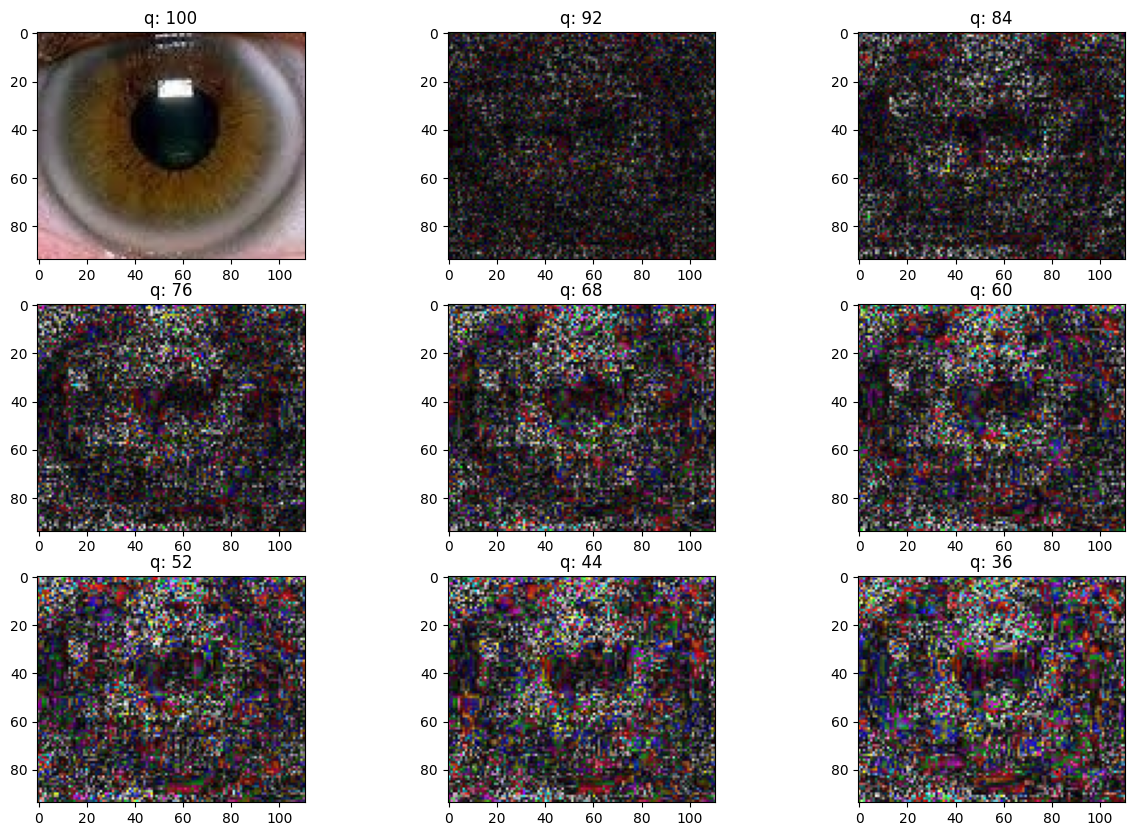

In [ ]:
# View random sample from the dataset
p = random_sample('/content/DATASET IRIS MATA/KOLESTEROL')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig=plt.figure(figsize=(15, 10))
for i in range(1, columns*rows +1):
    quality=init_val - (i-1) * 8
    img = compute_ela_cv(path=p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

# 📝Data Preprocessing
<p style="font-size:15px; font-family:verdana; line-height: 1.7em">The data will be split into three different categories: Training, Validation and Testing. The training data will be used to train the deep learning CNN model and its parameters will be fine tuned with the validation data. Finally, the performance of the data will be evaluated using the test data(data the model has not previously seen).</p>

In [ ]:
def resize_and_rescale(image):
    image = tf.image.resize(image, [224, 224])  # Resize the image to 224x224
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)  # Apply MobileNetV2 preprocessing
    return image

In [ ]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [ ]:
# Split the data into three categories.
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 128 validated image filenames belonging to 2 classes.
Found 32 validated image filenames belonging to 2 classes.
Found 40 validated image filenames belonging to 2 classes.


In [ ]:
print(train_images.class_indices)

# 🤹Training the model
<p style="font-size:15px; font-family:verdana; line-height: 1.7em">The model images will be subjected to a pre-trained CNN model called MobileNetV2. Three callbacks will be utilized to monitor the training. These are: Model Checkpoint, Early Stopping, Tensorboard callback. The summary of the model hyperparameter is shown as follows:</p>

**Batch size** : 32

**Epochs** : 100

**Input Shape** : (224, 224, 3)

**Output layer** : 2



In [ ]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# Create checkpoint callback
checkpoint_path = "iris_classification_model_checkpoint"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=True,
                                      monitor="val_accuracy",
                                      save_best_only=True)

In [ ]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 5 epochs
early_stopping = EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 5,
                               restore_best_weights = True) # if val loss decreases for 5 epochs in a row, stop training

# 🚄Training the model

In [ ]:
from tensorflow.keras.layers import Input
inputs = Input(shape=(224, 224, 3))
x = pretrained_model(inputs, training=False)  # Pass inputs through the pretrained model
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.45)(x)
outputs = Dense(2, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=100,
    callbacks=[
        early_stopping,
        create_tensorboard_callback("training_logs",
                                    "iris_classification"),
        checkpoint_callback,
    ]
)

Saving TensorBoard log files to: training_logs/iris_classification/20240702-213543
Epoch 1/100
4/4 [==============================] - 26s 3s/step - loss: 4.0694 - accuracy: 0.4531 - val_loss: 1.3313 - val_accuracy: 0.6250
Epoch 2/100
4/4 [==============================] - 7s 2s/step - loss: 2.4219 - accuracy: 0.5312 - val_loss: 1.4506 - val_accuracy: 0.5938
Epoch 3/100
4/4 [==============================] - 17s 4s/step - loss: 1.9702 - accuracy: 0.5703 - val_loss: 0.6924 - val_accuracy: 0.7188
Epoch 4/100
4/4 [==============================] - 9s 2s/step - loss: 1.4936 - accuracy: 0.6953 - val_loss: 0.4710 - val_accuracy: 0.7500
Epoch 5/100
4/4 [==============================] - 9s 2s/step - loss: 1.3370 - accuracy: 0.7266 - val_loss: 0.3810 - val_accuracy: 0.8438
Epoch 6/100
4/4 [==============================] - 7s 2s/step - loss: 1.6114 - accuracy: 0.6328 - val_loss: 0.3132 - val_accuracy: 0.8750
Epoch 7/100
4/4 [==============================] - 9s 2s/step - loss: 1.4242 - accuracy

In [ ]:
final_epoch = len(history.history['accuracy']) - 1
train_accuracy = history.history['accuracy'][final_epoch]
val_accuracy = history.history['val_accuracy'][final_epoch]

print(f"train_accuracy: {train_accuracy:.4f}")
print(f"val_accuracy: {val_accuracy:.4f}")

train_accuracy: 0.8672
val_accuracy: 0.9375


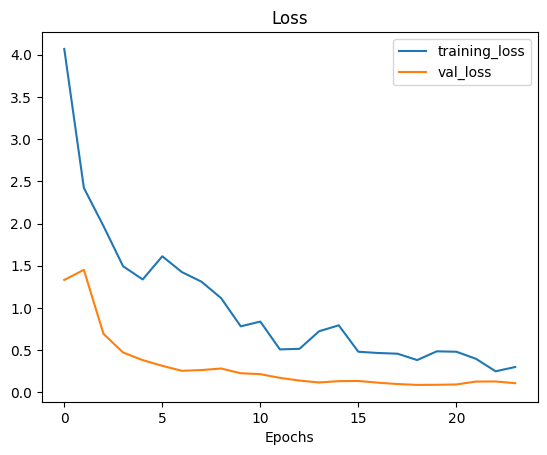

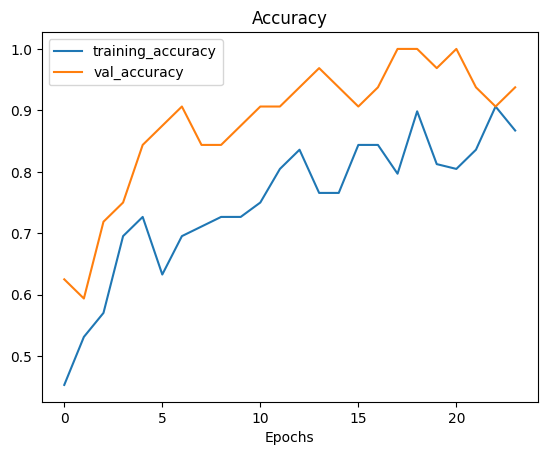

In [ ]:
plot_loss_curves(history)

In [ ]:
# Menyimpan model ke file
model.save('model1_skenario1 versi2.h5')

# Menampilkan pesan konfirmasi
print("Model berhasil disimpan.")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model berhasil disimpan.


# ✔️Model Evaluation
<p style="font-size:15px; font-family:verdana; line-height: 1.7em">The test dataset will be used to evaluate the performance of the model.One of the metrics that will be tested would be accuracy which measures the fraction of predictions the model got right. Other metrics are as follows:   </p>

<h3>Precision(P):</h3>
<p style="font-size:15px; font-family:verdana; line-height: 1.7em">The fraction of true positives (TP, correct predictions) from the total amount of relevant results, i.e., the sum of TP and false positives (FP). For multi-class classification problems, P is averaged among the classes. The following is the formula for precision.</p>

<h4> <center>$P=TP/(TP+FP)$</center></h4>

<h3>Recall(R): </h3>
<p style="font-size:15px; font-family:verdana; line-height: 1.7em">The fraction of TP from the total amount of TP and false negatives (FN). For multi-class classification problems, R gets averaged among all the classes. The following is the formula for recall.</p>
<h4><center>$R=TP/(TP+FN)$</center></h4>

<h3>F1 score(F1): </h3>

<p style="font-size:15px; font-family:verdana; line-height: 1.7em">The harmonic mean of precision and recall. For multi-class classification problems, F1 gets averaged among all the classes. The following is the formula for F1 score.</p>
<h4><center>$F1=2 * (TP * FP)/(TP+FP)$</center></h4>




In [ ]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.14740
Test Accuracy: 95.00%


# 📉Visualizing loss curves

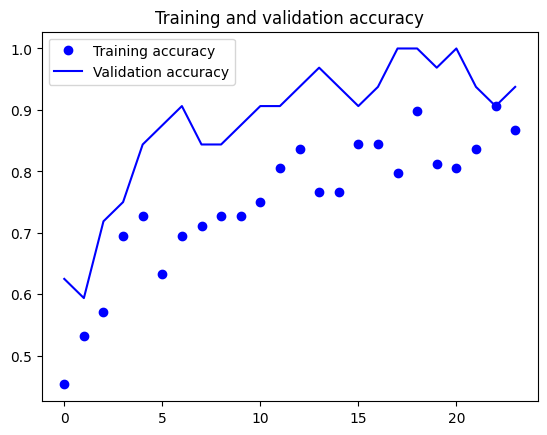

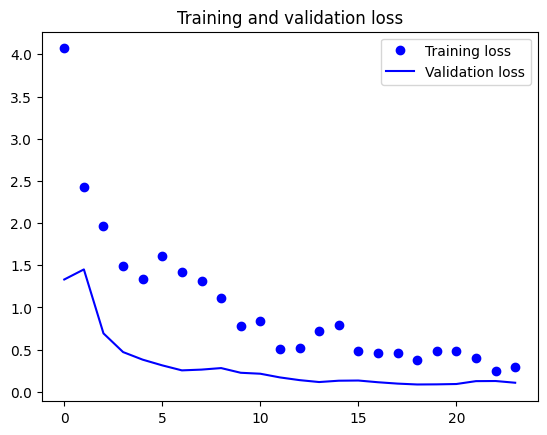

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
# Evaluasi model pada data pelatihan
train_loss, train_accuracy = model.evaluate(train_images)
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)

# Evaluasi model pada data validasi
val_loss, val_accuracy = model.evaluate(val_images)
print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)


4/4 [==============================] - 5s 1s/step - loss: 0.0447 - accuracy: 0.9844
Train Loss: 0.04474301263689995
Train Accuracy: 0.984375
1/1 [==============================] - 1s 1s/step - loss: 0.0868 - accuracy: 1.0000
Validation Loss: 0.08681480586528778
Validation Accuracy: 1.0


# 🔮Making predictions on the Test Data

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

2/2 [==============================] - 2s 432ms/step
The first 5 predictions: ['KOLESTEROL', 'KOLESTEROL', 'KOLESTEROL', 'NORMAL', 'NORMAL']


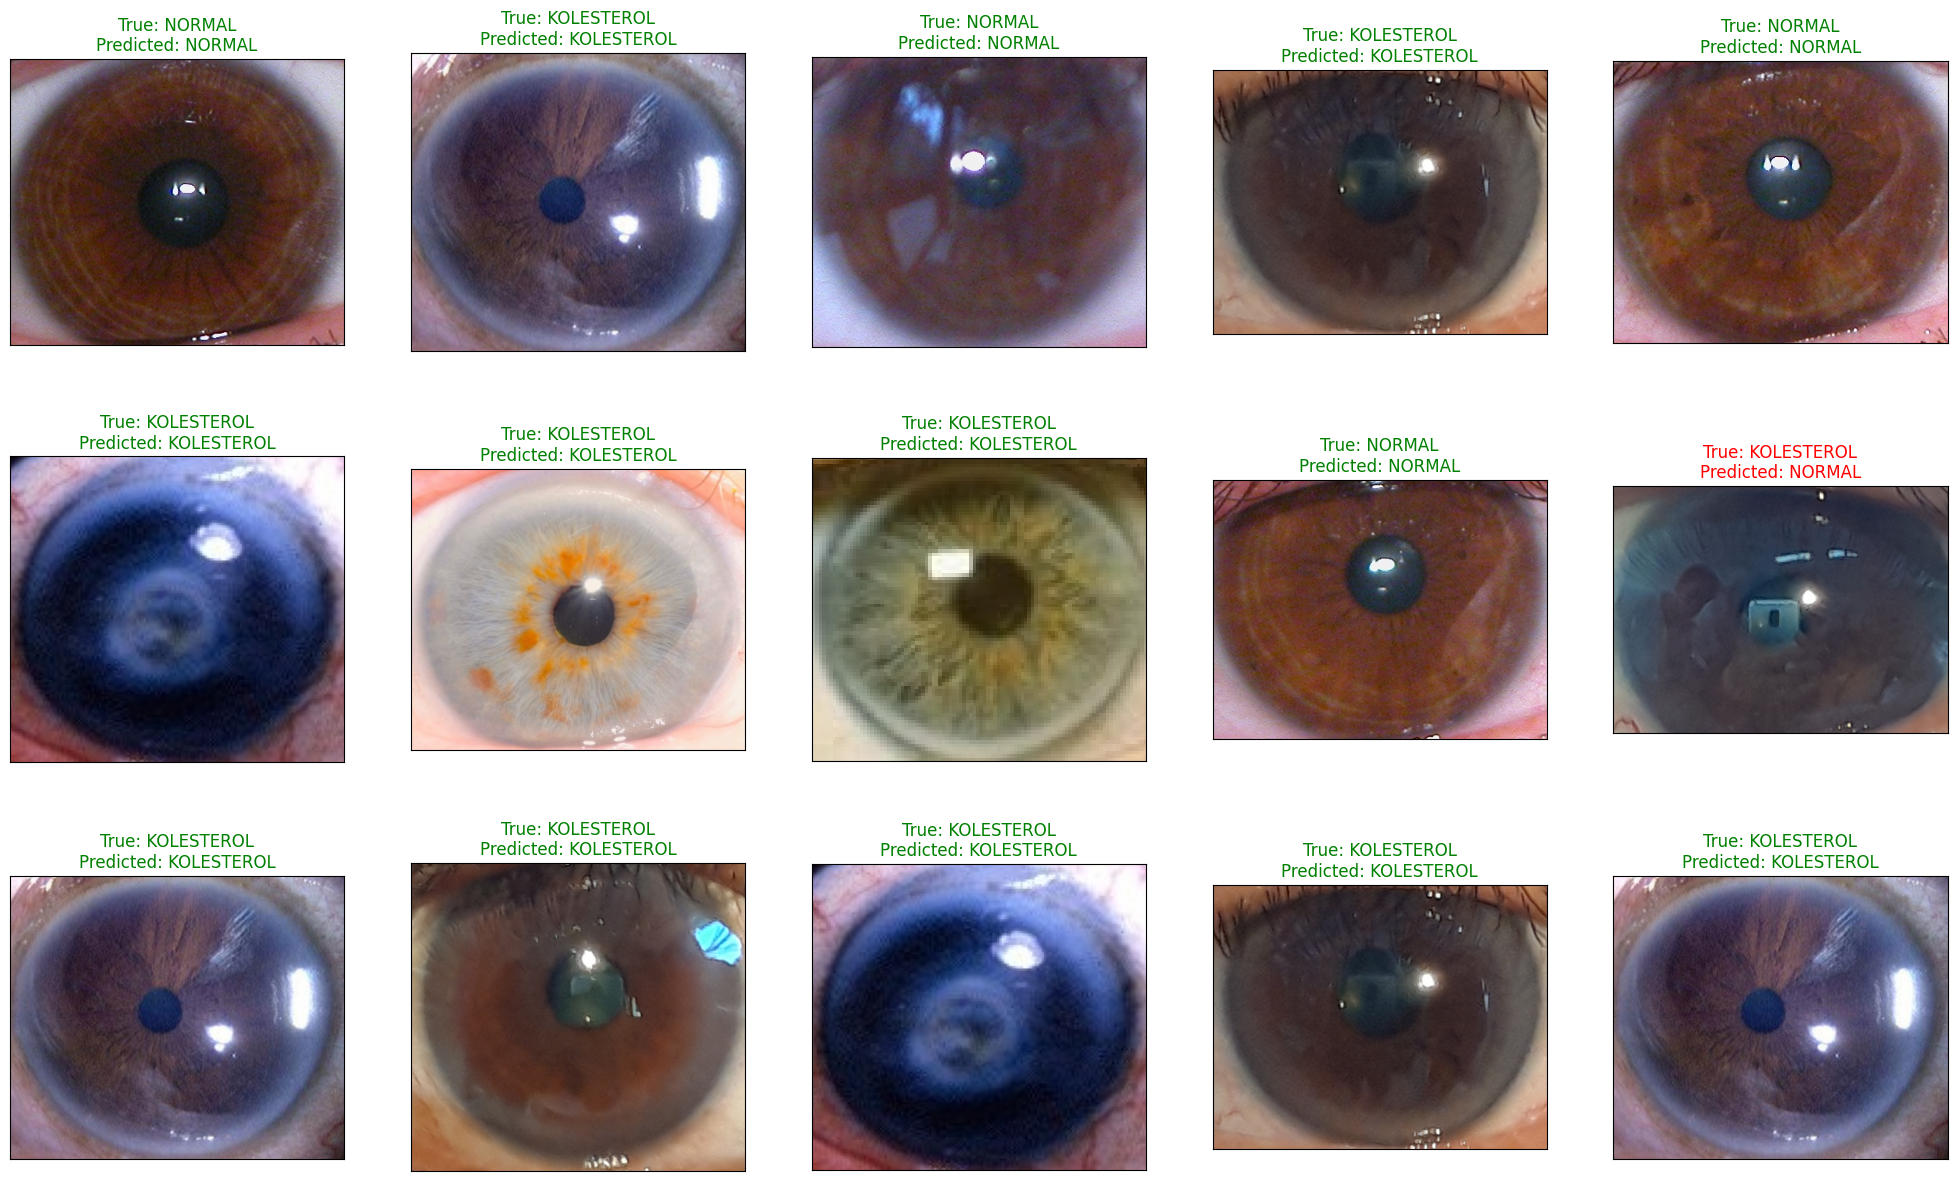

<Figure size 640x480 with 0 Axes>

In [ ]:
# Display 25 random pictures from the dataset with their labels
random_index = np.random.randint(0, len(test_df) - 1, 15)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[random_index[i]]))
    if test_df.Label.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.Label.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

# 📊Plotting the Classification Reports and Confusion Matrix

In [ ]:
from sklearn.metrics import classification_report

# Ensure y_test and pred have the same length
y_test = list(test_df.Label)
y_test_adjusted = y_test[:-11]
pred_adjusted = pred[:len(y_test_adjusted)]

# Generate the classification report
report = classification_report(y_test_adjusted, pred_adjusted, output_dict=True)

# Print the report
print("Classification Report:")
print(f"Precision: {report['macro avg']['precision']:.4f}")
print(f"Recall: {report['macro avg']['recall']:.4f}")
print(f"F1-score: {report['macro avg']['f1-score']:.4f}")
print(f"Accuracy: {report['accuracy']:.4f}")


Classification Report:
Precision: 0.9303
Recall: 0.9303
F1-score: 0.9303
Accuracy: 0.9310


2/2 [==============================] - 2s 236ms/step


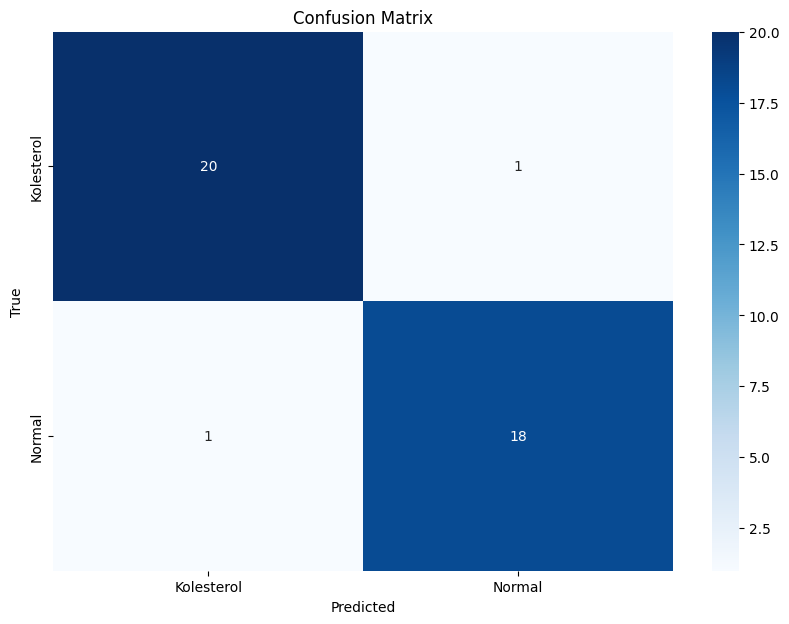

In [ ]:
# Predict the label of the test_images
pred_probabilities = model.predict(test_images)
pred_labels = np.argmax(pred_probabilities, axis=1)  # Convert probabilities to class labels

# Assuming true_labels and pred_labels are defined after predicting on test data
true_labels = test_images.classes  # Example: [0, 1, 0, 1, ...]

# Compute confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Kolesterol', 'Normal'], yticklabels=['Kolesterol', 'Normal'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from tensorflow.keras.models import load_model

# Muat model
model = load_model('/content/model1_skenario1 versi2.h5')


In [ ]:
import cv2
import numpy as np

# Path gambar yang ingin diuji
image_path = '/content/INDAH-KOLESTEROL.jpg'

# Muat gambar dan praproses sesuai dengan kebutuhan model
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Konversi BGR ke RGB jika perlu
image_resized = cv2.resize(image_rgb, (224, 224))  # Resize sesuai dengan kebutuhan model
image_normalized = image_resized / 255.0  # Normalisasi nilai piksel

# Tambahkan dimensi batch
image_test = np.expand_dims(image_normalized, axis=0)

# Lakukan prediksi
pred = model.predict(image_test)
predicted_class_index = np.argmax(pred)

# Label kelas yang diinginkan
class_labels = {0: 'NORMAL', 1: 'KOLESTEROL'}

# Lakukan pemetaan label
predicted_label = class_labels[predicted_class_index]

# Tampilkan hasil prediksi
print(f'Predicted label: {predicted_label}')


1/1 [==============================] - 0s 62ms/step
Predicted label: KOLESTEROL
